In [ ]:
%matplotlib inline


# Tensor transforms and JIT

This example illustrates various features that are now supported by the
`image transformations <transforms>` on Tensor images. In particular, we
show how image transforms can be performed on GPU, and how one can also script
them using JIT compilation.

Prior to v0.8.0, transforms in torchvision have traditionally been PIL-centric
and presented multiple limitations due to that. Now, since v0.8.0, transforms
implementations are Tensor and PIL compatible and we can achieve the following
new features:

- transform multi-band torch tensor images (with more than 3-4 channels)
- torchscript transforms together with your model for deployment
- support for GPU acceleration
- batched transformation such as for videos
- read and decode data directly as torch tensor with torchscript support (for PNG and JPEG image formats)

<div class="alert alert-info"><h4>Note</h4><p>These features are only possible with **Tensor** images.</p></div>


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

The :func:`~torchvision.io.read_image` function allows to read an image and
directly load it as a tensor



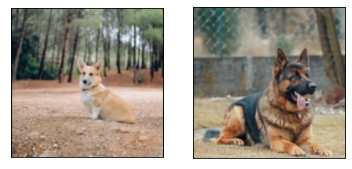

In [ ]:
dog1 = read_image(str(Path('assets') / '/content/data/dog1.jpg'))
dog2 = read_image(str(Path('assets') / '/content/data/dog2.jpg'))
show([dog1, dog2])

## Transforming images on GPU
Most transforms natively support tensors on top of PIL images (to visualize
the effect of the transforms, you may refer to see
`sphx_glr_auto_examples_plot_transforms.py`).
Using tensor images, we can run the transforms on GPUs if cuda is available!



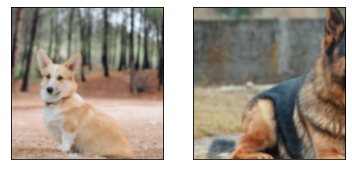

In [ ]:
import torch.nn as nn

transforms = torch.nn.Sequential(
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dog1 = dog1.to(device)
dog2 = dog2.to(device)

transformed_dog1 = transforms(dog1)
transformed_dog2 = transforms(dog2)
show([transformed_dog1, transformed_dog2])

## Scriptable transforms for easier deployment via torchscript
We now show how to combine image transformations and a model forward pass,
while using ``torch.jit.script`` to obtain a single scripted module.

Let's define a ``Predictor`` module that transforms the input tensor and then
applies an ImageNet model on it.



In [ ]:
from torchvision.models import resnet18, ResNet18_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

Now, let's define scripted and non-scripted instances of ``Predictor`` and
apply it on multiple tensor images of the same size



In [ ]:
predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([dog1, dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


RuntimeError: ignored

We can verify that the prediction of the scripted and non-scripted models are
the same:



In [ ]:
import json

with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Since the model is scripted, it can be easily dumped on disk and re-used



In [ ]:
import tempfile

with tempfile.NamedTemporaryFile() as f:
    scripted_predictor.save(f.name)

    dumped_scripted_predictor = torch.jit.load(f.name)
    res_scripted_dumped = dumped_scripted_predictor(batch)
assert (res_scripted_dumped == res_scripted).all()